In [1]:
# polarization grating from C. Oh and M.J. Escuti, Optics Letters, Vol. 33, No. 20, pp. 2287-9, 2008
# note: reference uses z as the propagation direction and y as the out-of-plane direction; this script uses x and z, respectively
import math

import matplotlib.pyplot as plt
import numpy as np

import meep as mp

In [2]:

resolution = 50  # pixels/μm

dpml = 1.0  # PML thickness
dsub = 1.0  # substrate thickness
dpad = 1.0  # padding thickness

k_point = mp.Vector3(0, 0, 0)

pml_layers = [mp.PML(thickness=dpml, direction=mp.X)]

n_0 = 1.55
delta_n = 0.159
epsilon_diag = mp.Matrix(
    mp.Vector3(n_0**2, 0, 0),
    mp.Vector3(0, n_0**2, 0),
    mp.Vector3(0, 0, (n_0 + delta_n) ** 2),
)

wvl = 0.54  # center wavelength
fcen = 1 / wvl  # center frequency

In [3]:
def pol_grating(d, ph, gp, nmode):
    sx = dpml + dsub + d + d + dpad + dpml
    sy = gp

    cell_size = mp.Vector3(sx, sy, 0)

    # twist angle of nematic director; from equation 1b
    def phi(p):
        xx = p.x - (-0.5 * sx + dpml + dsub)
        if (xx >= 0) and (xx <= d):
            return math.pi * p.y / gp + ph * xx / d
        else:
            return math.pi * p.y / gp - ph * xx / d + 2 * ph

    # return the anisotropic permittivity tensor for a uniaxial, twisted nematic liquid crystal
    def lc_mat(p):
        # rotation matrix for rotation around x axis
        Rx = mp.Matrix(
            mp.Vector3(1, 0, 0),
            mp.Vector3(0, math.cos(phi(p)), math.sin(phi(p))),
            mp.Vector3(0, -math.sin(phi(p)), math.cos(phi(p))),
        )
        lc_epsilon = Rx * epsilon_diag * Rx.transpose()
        lc_epsilon_diag = mp.Vector3(lc_epsilon[0].x, lc_epsilon[1].y, lc_epsilon[2].z)
        lc_epsilon_offdiag = mp.Vector3(
            lc_epsilon[1].x, lc_epsilon[2].x, lc_epsilon[2].y
        )
        return mp.Medium(
            epsilon_diag=lc_epsilon_diag, epsilon_offdiag=lc_epsilon_offdiag
        )

    geometry = [
        mp.Block(
            center=mp.Vector3(-0.5 * sx + 0.5 * (dpml + dsub)),
            size=mp.Vector3(dpml + dsub, mp.inf, mp.inf),
            material=mp.Medium(index=n_0),
        ),
        mp.Block(
            center=mp.Vector3(-0.5 * sx + dpml + dsub + d),
            size=mp.Vector3(2 * d, mp.inf, mp.inf),
            material=lc_mat,
        ),
    ]

    # linear-polarized planewave pulse source
    src_pt = mp.Vector3(-0.5 * sx + dpml + 0.3 * dsub, 0, 0)
    sources = [
        mp.Source(
            mp.GaussianSource(fcen, fwidth=0.05 * fcen),
            component=mp.Ez,
            center=src_pt,
            size=mp.Vector3(0, sy, 0),
        ),
        mp.Source(
            mp.GaussianSource(fcen, fwidth=0.05 * fcen),
            component=mp.Ey,
            center=src_pt,
            size=mp.Vector3(0, sy, 0),
        ),
    ]

    sim = mp.Simulation(
        resolution=resolution,
        cell_size=cell_size,
        boundary_layers=pml_layers,
        k_point=k_point,
        sources=sources,
        default_material=mp.Medium(index=n_0),
    )

    tran_pt = mp.Vector3(0.5 * sx - dpml - 0.5 * dpad, 0, 0)
    tran_flux = sim.add_flux(
        fcen, 0, 1, mp.FluxRegion(center=tran_pt, size=mp.Vector3(0, sy, 0))
    )

    sim.run(until_after_sources=100)

    input_flux = mp.get_fluxes(tran_flux)

    sim.reset_meep()

    sim = mp.Simulation(
        resolution=resolution,
        cell_size=cell_size,
        boundary_layers=pml_layers,
        k_point=k_point,
        sources=sources,
        geometry=geometry,
    )

    tran_flux = sim.add_flux(
        fcen, 0, 1, mp.FluxRegion(center=tran_pt, size=mp.Vector3(0, sy, 0))
    )

    sim.run(until_after_sources=300)

    res1 = sim.get_eigenmode_coefficients(
        tran_flux, range(1, nmode + 1), eig_parity=mp.ODD_Z + mp.EVEN_Y
    )
    res2 = sim.get_eigenmode_coefficients(
        tran_flux, range(1, nmode + 1), eig_parity=mp.EVEN_Z + mp.ODD_Y
    )
    angles = [math.degrees(math.acos(kdom.x / fcen)) for kdom in res1.kdom]

    return input_flux[0], angles, res1.alpha[:, 0, 0], res2.alpha[:, 0, 0]

-----------
Initializing structure...
time for choose_chunkdivision = 3.19481e-05 s
Working in 2D dimensions.
Computational cell is 4.1 x 6.5 x 0 with resolution 50
time for set_epsilon = 0.0328288 s
-----------
Meep progress: 119.94/208.0 = 57.7% done in 4.0s, 2.9s to go
on time step 11994 (time=119.94), 0.000333531 s/step


run 0 finished at t = 208.0 (20800 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 7.70092e-05 s
Working in 2D dimensions.
Computational cell is 4.1 x 6.5 x 0 with resolution 50
     block, center = (-1.05,0,0)
          size (2,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.4025,2.4025,2.4025)
     block, center = (1.80411e-16,0,0)
          size (0.1,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.3725 s
-----------
Meep progress: 112.87/408.0 = 27.7% done in 4.0s, 10.5s to go
on time step 11287 (time=112.87), 0.000354429 s/step
Meep progress: 224.67000000000002/408.0 = 55.1% done in 8.0s, 6.5s to go
on time step 22467 (time=224.67), 0.000357784 s/step
Meep progress: 337.85/408.0 = 82.8% done in 12.0s, 2.5s to go
on time step 33788 (time=337.88), 0.000353339 s/step
run 0 finished at t = 408.0 (40800 timesteps)
MPB solved for frequency_1(1.85185,0,0) = 1.85185 aft

tran (uniaxial):, 0, 0.00, 0.90149
tran (uniaxial):, 1, 4.77, 0.01761
tran (uniaxial):, 2, 9.56, 0.00000
tran (uniaxial):, 3, 14.43, 0.00000
tran (uniaxial):, 4, 19.41, 0.00000
-----------
Initializing structure...
time for choose_chunkdivision = 3.60012e-05 s
Working in 2D dimensions.
Computational cell is 4.4 x 6.5 x 0 with resolution 50
time for set_epsilon = 0.05109 s
-----------
Meep progress: 113.05/208.0 = 54.4% done in 4.0s, 3.4s to go
on time step 11305 (time=113.05), 0.000353846 s/step


run 0 finished at t = 208.0 (20800 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.88486e-05 s
Working in 2D dimensions.
Computational cell is 4.4 x 6.5 x 0 with resolution 50
     block, center = (-1.2,0,0)
          size (2,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.4025,2.4025,2.4025)
     block, center = (-1.66533e-16,0,0)
          size (0.4,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 1.30064 s
-----------
Meep progress: 105.16/408.0 = 25.8% done in 4.0s, 11.5s to go
on time step 10516 (time=105.16), 0.000380388 s/step
Meep progress: 211.0/408.0 = 51.7% done in 8.0s, 7.5s to go
on time step 21101 (time=211.01), 0.000377902 s/step
Meep progress: 318.03000000000003/408.0 = 77.9% done in 12.0s, 3.4s to go
on time step 31806 (time=318.06), 0.00037367 s/step
run 0 finished at t = 408.0 (40800 timesteps)
MPB solved for frequency_1(1.85185,0,0) = 1.85185 afte

tran (uniaxial):, 0, 0.00, 0.87757
tran (uniaxial):, 1, 4.77, 0.03593
tran (uniaxial):, 2, 9.56, 0.00000
tran (uniaxial):, 3, 14.43, 0.00000
tran (uniaxial):, 4, 19.41, 0.00000
-----------
Initializing structure...
time for choose_chunkdivision = 3.91006e-05 s
Working in 2D dimensions.
Computational cell is 4.6 x 6.5 x 0 with resolution 50
time for set_epsilon = 0.054873 s
-----------
Meep progress: 106.53/208.0 = 51.2% done in 4.0s, 3.8s to go
on time step 10653 (time=106.53), 0.000375497 s/step


run 0 finished at t = 208.0 (20800 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.90871e-05 s
Working in 2D dimensions.
Computational cell is 4.6 x 6.5 x 0 with resolution 50
     block, center = (-1.3,0,0)
          size (2,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.4025,2.4025,2.4025)
     block, center = (2.22045e-16,0,0)
          size (0.6,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 1.96821 s
-----------
Meep progress: 63.440000000000005/408.0 = 15.5% done in 4.0s, 21.7s to go
on time step 6344 (time=63.44), 0.000630572 s/step
Meep progress: 149.15/408.0 = 36.6% done in 8.0s, 13.9s to go
on time step 14916 (time=149.16), 0.000466697 s/step
Meep progress: 214.77/408.0 = 52.6% done in 12.0s, 10.8s to go
on time step 21481 (time=214.81), 0.00060934 s/step
Meep progress: 299.64/408.0 = 73.4% done in 16.0s, 5.8s to go
on time step 29970 (time=299.7), 0.000

tran (twisted):, 0, 0.00, 0.77804
tran (twisted):, 1, 4.77, 0.07879
tran (twisted):, 2, 9.56, 0.00000
tran (twisted):, 3, 14.43, 0.00000
tran (twisted):, 4, 19.41, 0.00000
-----------
Initializing structure...
time for choose_chunkdivision = 5.79357e-05 s
Working in 2D dimensions.
Computational cell is 4.4 x 6.5 x 0 with resolution 50
time for set_epsilon = 0.0444221 s
-----------
Meep progress: 101.69/208.0 = 48.9% done in 4.0s, 4.2s to go
on time step 10169 (time=101.69), 0.00039338 s/step
Meep progress: 205.15/208.0 = 98.6% done in 8.0s, 0.1s to go
on time step 20516 (time=205.16), 0.000386617 s/step


run 0 finished at t = 208.0 (20800 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.60012e-05 s
Working in 2D dimensions.
Computational cell is 4.4 x 6.5 x 0 with resolution 50
     block, center = (-1.2,0,0)
          size (2,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.4025,2.4025,2.4025)
     block, center = (-1.66533e-16,0,0)
          size (0.4,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 1.36045 s
-----------
Meep progress: 101.43/408.0 = 24.9% done in 4.0s, 12.1s to go
on time step 10143 (time=101.43), 0.000394398 s/step
Meep progress: 174.38/408.0 = 42.7% done in 8.0s, 10.7s to go
on time step 17439 (time=174.39), 0.00054829 s/step
Meep progress: 272.55/408.0 = 66.8% done in 12.0s, 6.0s to go
on time step 27257 (time=272.57), 0.000407425 s/step
Meep progress: 368.46/408.0 = 90.3% done in 16.0s, 1.7s to go
on time step 36849 (time=368.49), 0.000417039 s/

tran (twisted):, 0, 0.00, 0.53587
tran (twisted):, 1, 4.77, 0.20145
tran (twisted):, 2, 9.56, 0.00000
tran (twisted):, 3, 14.43, 0.00000
tran (twisted):, 4, 19.41, 0.00000
-----------
Initializing structure...
time for choose_chunkdivision = 4.41074e-05 s
Working in 2D dimensions.
Computational cell is 4.6 x 6.5 x 0 with resolution 50
time for set_epsilon = 0.0502431 s
-----------
Meep progress: 108.5/208.0 = 52.2% done in 4.0s, 3.7s to go
on time step 10850 (time=108.5), 0.000368694 s/step


run 0 finished at t = 208.0 (20800 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.09944e-05 s
Working in 2D dimensions.
Computational cell is 4.6 x 6.5 x 0 with resolution 50
     block, center = (-1.3,0,0)
          size (2,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.4025,2.4025,2.4025)
     block, center = (1.66533e-16,0,0)
          size (0.6,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 1.98156 s
-----------
Meep progress: 85.51/408.0 = 21.0% done in 4.0s, 15.1s to go
on time step 8551 (time=85.51), 0.000467844 s/step
Meep progress: 186.39000000000001/408.0 = 45.7% done in 8.0s, 9.5s to go
on time step 18640 (time=186.4), 0.000396493 s/step
Meep progress: 285.72/408.0 = 70.0% done in 12.0s, 5.1s to go
on time step 28575 (time=285.75), 0.000402652 s/step
Meep progress: 386.97/408.0 = 94.8% done in 16.0s, 0.9s to go
on time step 38700 (time=387), 0.00039506

tran (twisted):, 0, 0.00, 0.20188
tran (twisted):, 1, 4.77, 0.37080
tran (twisted):, 2, 9.56, 0.00000
tran (twisted):, 3, 14.43, 0.00000
tran (twisted):, 4, 19.41, 0.00000
-----------
Initializing structure...
time for choose_chunkdivision = 5.98431e-05 s
Working in 2D dimensions.
Computational cell is 4.9 x 6.5 x 0 with resolution 50
time for set_epsilon = 0.0568271 s
-----------
Meep progress: 93.10000000000001/208.0 = 44.8% done in 4.0s, 4.9s to go
on time step 9310 (time=93.1), 0.000429673 s/step
Meep progress: 184.47/208.0 = 88.7% done in 8.0s, 1.0s to go
on time step 18447 (time=184.47), 0.000437792 s/step


run 0 finished at t = 208.0 (20800 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.40939e-05 s
Working in 2D dimensions.
Computational cell is 4.9 x 6.5 x 0 with resolution 50
     block, center = (-1.45,0,0)
          size (2,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.4025,2.4025,2.4025)
     block, center = (-1.66533e-16,0,0)
          size (0.9,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 4.42209 s
-----------
Meep progress: 75.99/408.0 = 18.6% done in 4.0s, 17.5s to go
on time step 7599 (time=75.99), 0.000526431 s/step
Meep progress: 161.78/408.0 = 39.7% done in 8.0s, 12.2s to go
on time step 16179 (time=161.79), 0.000466231 s/step
Meep progress: 251.1/408.0 = 61.5% done in 12.0s, 7.5s to go
on time step 25111 (time=251.11), 0.000447837 s/step
Meep progress: 337.49/408.0 = 82.7% done in 16.0s, 3.3s to go
on time step 33753 (time=337.53), 0.000462912 s/st

tran (twisted):, 0, 0.00, 0.06207
tran (twisted):, 1, 4.77, 0.43863
tran (twisted):, 2, 9.56, 0.00000
tran (twisted):, 3, 14.43, 0.00000
tran (twisted):, 4, 19.41, 0.00000
-----------
Initializing structure...
time for choose_chunkdivision = 4.00543e-05 s
Working in 2D dimensions.
Computational cell is 5.1 x 6.5 x 0 with resolution 50
time for set_epsilon = 0.0663419 s
-----------
Meep progress: 91.99/208.0 = 44.2% done in 4.0s, 5.0s to go
on time step 9199 (time=91.99), 0.000434866 s/step
Meep progress: 183.55/208.0 = 88.2% done in 8.0s, 1.1s to go
on time step 18356 (time=183.56), 0.000436847 s/step


run 0 finished at t = 208.0 (20800 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.31402e-05 s
Working in 2D dimensions.
Computational cell is 5.1 x 6.5 x 0 with resolution 50
     block, center = (-1.55,0,0)
          size (2,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.4025,2.4025,2.4025)
     block, center = (2.22045e-16,0,0)
          size (1.1,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 3.77777 s
-----------
Meep progress: 83.68/408.0 = 20.5% done in 4.0s, 15.5s to go
on time step 8368 (time=83.68), 0.000478091 s/step
Meep progress: 168.65/408.0 = 41.3% done in 8.0s, 11.4s to go
on time step 16866 (time=168.66), 0.000470718 s/step
Meep progress: 254.52/408.0 = 62.4% done in 12.0s, 7.2s to go
on time step 25453 (time=254.53), 0.000465843 s/step
Meep progress: 339.61/408.0 = 83.2% done in 16.0s, 3.2s to go
on time step 33964 (time=339.64), 0.000470022 s/st

tran (twisted):, 0, 0.00, 0.00832
tran (twisted):, 1, 4.77, 0.46683
tran (twisted):, 2, 9.56, 0.00000
tran (twisted):, 3, 14.43, 0.00000
tran (twisted):, 4, 19.41, 0.00000
-----------
Initializing structure...
time for choose_chunkdivision = 4.00543e-05 s
Working in 2D dimensions.
Computational cell is 5.3 x 6.5 x 0 with resolution 50
time for set_epsilon = 0.0633612 s
-----------
Meep progress: 92.01/208.0 = 44.2% done in 4.0s, 5.0s to go
on time step 9201 (time=92.01), 0.000434759 s/step
Meep progress: 184.15/208.0 = 88.5% done in 8.0s, 1.0s to go
on time step 18416 (time=184.16), 0.000434113 s/step


run 0 finished at t = 208.0 (20800 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.29018e-05 s
Working in 2D dimensions.
Computational cell is 5.3 x 6.5 x 0 with resolution 50
     block, center = (-1.65,0,0)
          size (2,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.4025,2.4025,2.4025)
     block, center = (-2.22045e-16,0,0)
          size (1.3,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 5.25395 s
-----------
Meep progress: 84.79/408.0 = 20.8% done in 4.0s, 15.2s to go
on time step 8479 (time=84.79), 0.000471819 s/step
Meep progress: 168.13/408.0 = 41.2% done in 8.0s, 11.4s to go
on time step 16813 (time=168.13), 0.00047997 s/step
Meep progress: 252.8/408.0 = 62.0% done in 12.0s, 7.4s to go
on time step 25281 (time=252.81), 0.00047239 s/step
Meep progress: 337.43/408.0 = 82.7% done in 16.0s, 3.3s to go
on time step 33745 (time=337.45), 0.000472624 s/step

tran (uniaxial):, 0, 0.00, 0.06115
tran (uniaxial):, 1, 4.77, 0.44397
tran (uniaxial):, 2, 9.56, 0.00000
tran (uniaxial):, 3, 14.43, 0.00000
tran (uniaxial):, 4, 19.41, 0.00000
-----------
Initializing structure...
time for choose_chunkdivision = 3.88622e-05 s
Working in 2D dimensions.
Computational cell is 6.8 x 6.5 x 0 with resolution 50
time for set_epsilon = 0.0699909 s
-----------
Meep progress: 70.14/208.0 = 33.7% done in 4.0s, 7.9s to go
on time step 7014 (time=70.14), 0.000570326 s/step
Meep progress: 140.73/208.0 = 67.7% done in 8.0s, 3.8s to go
on time step 14074 (time=140.74), 0.000566648 s/step


run 0 finished at t = 208.0 (20800 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.60012e-05 s
Working in 2D dimensions.
Computational cell is 6.8 x 6.5 x 0 with resolution 50
     block, center = (-2.4,0,0)
          size (2,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.4025,2.4025,2.4025)
     block, center = (-2.22045e-16,0,0)
          size (2.8,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 9.51729 s
-----------
Meep progress: 62.04/408.0 = 15.2% done in 4.0s, 22.3s to go
on time step 6204 (time=62.04), 0.00064478 s/step
Meep progress: 110.96000000000001/408.0 = 27.2% done in 8.0s, 21.4s to go
on time step 11097 (time=110.97), 0.000817558 s/step
Meep progress: 173.35/408.0 = 42.5% done in 12.0s, 16.2s to go
on time step 17336 (time=173.36), 0.00064115 s/step
Meep progress: 236.11/408.0 = 57.9% done in 16.0s, 11.6s to go
on time step 23613 (time=236.13), 0.00

tran (twisted):, 0, 0.00, 0.00044
tran (twisted):, 1, 4.77, 0.46896
tran (twisted):, 2, 9.56, 0.00000
tran (twisted):, 3, 14.43, 0.00000
tran (twisted):, 4, 19.41, 0.00000
-----------
Initializing structure...
time for choose_chunkdivision = 6.48499e-05 s
Working in 2D dimensions.
Computational cell is 5.8 x 6.5 x 0 with resolution 50
time for set_epsilon = 0.0619361 s
-----------
Meep progress: 80.48/208.0 = 38.7% done in 4.0s, 6.3s to go
on time step 8048 (time=80.48), 0.000497067 s/step
Meep progress: 140.6/208.0 = 67.6% done in 8.0s, 3.8s to go
on time step 14061 (time=140.61), 0.000665293 s/step


run 0 finished at t = 208.0 (20800 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.50475e-05 s
Working in 2D dimensions.
Computational cell is 5.8 x 6.5 x 0 with resolution 50
     block, center = (-1.9,0,0)
          size (2,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.4025,2.4025,2.4025)
     block, center = (-2.22045e-16,0,0)
          size (1.8,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 6.11059 s
-----------
Meep progress: 76.95/408.0 = 18.9% done in 4.0s, 17.2s to go
on time step 7695 (time=76.95), 0.000519842 s/step
Meep progress: 150.05/408.0 = 36.8% done in 8.0s, 13.8s to go
on time step 15006 (time=150.06), 0.000547165 s/step
Meep progress: 224.09/408.0 = 54.9% done in 12.0s, 9.8s to go
on time step 22412 (time=224.12), 0.000540158 s/step
Meep progress: 297.63/408.0 = 72.9% done in 16.0s, 5.9s to go
on time step 29767 (time=297.67), 0.00054388 s/ste

tran (uniaxial):, 0, 0.00, 0.04619
tran (uniaxial):, 1, 4.77, 0.45139
tran (uniaxial):, 2, 9.56, 0.00000
tran (uniaxial):, 3, 14.43, 0.00000
tran (uniaxial):, 4, 19.41, 0.00000
-----------
Initializing structure...
time for choose_chunkdivision = 5.10216e-05 s
Working in 2D dimensions.
Computational cell is 7.8 x 6.5 x 0 with resolution 50
time for set_epsilon = 0.0847681 s
-----------
Meep progress: 58.03/208.0 = 27.9% done in 4.0s, 10.3s to go
on time step 5803 (time=58.03), 0.000689323 s/step
Meep progress: 118.72/208.0 = 57.1% done in 8.0s, 6.0s to go
on time step 11873 (time=118.73), 0.000659052 s/step
Meep progress: 177.93/208.0 = 85.5% done in 12.0s, 2.0s to go
on time step 17795 (time=177.95), 0.000675544 s/step


run 0 finished at t = 208.0 (20800 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.79086e-05 s
Working in 2D dimensions.
Computational cell is 7.8 x 6.5 x 0 with resolution 50
     block, center = (-2.9,0,0)
          size (2,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.4025,2.4025,2.4025)
     block, center = (-2.22045e-16,0,0)
          size (3.8,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
subpixel-averaging is 78.5435% done, 1.10145 s remaining
subpixel-averaging is 78.5435% done, 1.09939 s remaining
subpixel-averaging is 77.4821% done, 1.16694 s remaining
time for set_epsilon = 13.0218 s
-----------
Meep progress: 34.54/408.0 = 8.5% done in 4.0s, 43.3s to go
on time step 3454 (time=34.54), 0.00115815 s/step
Meep progress: 82.81/408.0 = 20.3% done in 8.0s, 31.4s to go
on time step 8282 (time=82.82), 0.000828619 s/step
Meep progress: 131.86/408.0 = 32.3% done in 12.0s, 25.1s to g

tran (uniaxial):, 0, 0.00, 0.14892
tran (uniaxial):, 1, 4.77, 0.39054
tran (uniaxial):, 2, 9.56, 0.00000
tran (uniaxial):, 3, 14.43, 0.00000
tran (uniaxial):, 4, 19.41, 0.00000
-----------
Initializing structure...
time for choose_chunkdivision = 5.00679e-05 s
Working in 2D dimensions.
Computational cell is 8.2 x 6.5 x 0 with resolution 50
time for set_epsilon = 0.097178 s
-----------
Meep progress: 40.68/208.0 = 19.6% done in 4.0s, 16.5s to go
on time step 4068 (time=40.68), 0.000983409 s/step
Meep progress: 90.5/208.0 = 43.5% done in 8.0s, 10.4s to go
on time step 9050 (time=90.5), 0.000802934 s/step
Meep progress: 143.39000000000001/208.0 = 68.9% done in 12.0s, 5.4s to go
on time step 14339 (time=143.39), 0.000756437 s/step
Meep progress: 197.35/208.0 = 94.9% done in 16.0s, 0.9s to go
on time step 19736 (time=197.36), 0.000741252 s/step


run 0 finished at t = 208.0 (20800 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.71933e-05 s
Working in 2D dimensions.
Computational cell is 8.2 x 6.5 x 0 with resolution 50
     block, center = (-3.1,0,0)
          size (2,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.4025,2.4025,2.4025)
     block, center = (4.44089e-16,0,0)
          size (4.2,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
subpixel-averaging is 72.4671% done, 1.54117 s remaining
subpixel-averaging is 72.4671% done, 1.52541 s remaining
subpixel-averaging is 72.4671% done, 1.521 s remaining
time for set_epsilon = 14.5889 s
-----------
Meep progress: 33.42/408.0 = 8.2% done in 4.0s, 44.8s to go
on time step 3342 (time=33.42), 0.0011971 s/step
Meep progress: 75.91/408.0 = 18.6% done in 8.0s, 35.0s to go
on time step 7592 (time=75.92), 0.000941348 s/step
Meep progress: 119.24000000000001/408.0 = 29.2% done in 12.0s, 29

tran (twisted):, 0, 0.00, 0.11432
tran (twisted):, 1, 4.77, 0.40721
tran (twisted):, 2, 9.56, 0.00000
tran (twisted):, 3, 14.43, 0.00000
tran (twisted):, 4, 19.41, 0.00000
-----------
Initializing structure...
time for choose_chunkdivision = 4.41074e-05 s
Working in 2D dimensions.
Computational cell is 6.3 x 6.5 x 0 with resolution 50
time for set_epsilon = 0.0693309 s
-----------
Meep progress: 74.17/208.0 = 35.7% done in 4.0s, 7.2s to go
on time step 7417 (time=74.17), 0.000539394 s/step
Meep progress: 147.9/208.0 = 71.1% done in 8.0s, 3.3s to go
on time step 14791 (time=147.91), 0.0005425 s/step


run 0 finished at t = 208.0 (20800 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.60012e-05 s
Working in 2D dimensions.
Computational cell is 6.3 x 6.5 x 0 with resolution 50
     block, center = (-2.15,0,0)
          size (2,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.4025,2.4025,2.4025)
     block, center = (-2.22045e-16,0,0)
          size (2.3,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 9.0326 s
-----------
Meep progress: 67.93/408.0 = 16.6% done in 4.0s, 20.0s to go
on time step 6793 (time=67.93), 0.000588898 s/step
Meep progress: 136.09/408.0 = 33.4% done in 8.0s, 16.0s to go
on time step 13609 (time=136.09), 0.000586874 s/step
Meep progress: 202.39000000000001/408.0 = 49.6% done in 12.0s, 12.2s to go
on time step 20239 (time=202.39), 0.000603379 s/step
Meep progress: 268.88/408.0 = 65.9% done in 16.0s, 8.3s to go
on time step 26889 (time=268.89), 0.0

tran (uniaxial):, 0, 0.00, 0.28773
tran (uniaxial):, 1, 4.77, 0.32126
tran (uniaxial):, 2, 9.56, 0.00000
tran (uniaxial):, 3, 14.43, 0.00000
tran (uniaxial):, 4, 19.41, 0.00000
-----------
Initializing structure...
time for choose_chunkdivision = 5.10216e-05 s
Working in 2D dimensions.
Computational cell is 8.6 x 6.5 x 0 with resolution 50
time for set_epsilon = 0.0956481 s
-----------
Meep progress: 39.7/208.0 = 19.1% done in 4.0s, 17.0s to go
on time step 3970 (time=39.7), 0.00100775 s/step
Meep progress: 92.19/208.0 = 44.3% done in 8.0s, 10.1s to go
on time step 9219 (time=92.19), 0.000762369 s/step
Meep progress: 146.54/208.0 = 70.5% done in 12.0s, 5.0s to go
on time step 14655 (time=146.55), 0.000735908 s/step
Meep progress: 200.17000000000002/208.0 = 96.2% done in 16.0s, 0.6s to go
on time step 20019 (time=200.19), 0.000745794 s/step


run 0 finished at t = 208.0 (20800 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 4.19617e-05 s
Working in 2D dimensions.
Computational cell is 8.6 x 6.5 x 0 with resolution 50
     block, center = (-3.3,0,0)
          size (2,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.4025,2.4025,2.4025)
     block, center = (-4.44089e-16,0,0)
          size (4.6,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
subpixel-averaging is 70.8589% done, 1.66989 s remaining
subpixel-averaging is 68.0618% done, 1.90504 s remaining
subpixel-averaging is 68.0618% done, 1.88604 s remaining
time for set_epsilon = 15.7458 s
-----------
Meep progress: 33.410000000000004/408.0 = 8.2% done in 4.0s, 44.9s to go
on time step 3341 (time=33.41), 0.0011974 s/step
Meep progress: 78.02/408.0 = 19.1% done in 8.0s, 33.8s to go
on time step 7803 (time=78.03), 0.000896613 s/step
Meep progress: 122.9/408.0 = 30.1% done in 12.0s,

tran (uniaxial):, 0, 0.00, 0.39609
tran (uniaxial):, 1, 4.77, 0.26606
tran (uniaxial):, 2, 9.56, 0.00000
tran (uniaxial):, 3, 14.43, 0.00000
tran (uniaxial):, 4, 19.41, 0.00000
-----------
Initializing structure...
time for choose_chunkdivision = 5.10216e-05 s
Working in 2D dimensions.
Computational cell is 8.8 x 6.5 x 0 with resolution 50
time for set_epsilon = 0.104373 s
-----------
Meep progress: 51.56/208.0 = 24.8% done in 4.0s, 12.1s to go
on time step 5156 (time=51.56), 0.000775867 s/step
Meep progress: 101.23/208.0 = 48.7% done in 8.0s, 8.4s to go
on time step 10124 (time=101.24), 0.000805267 s/step
Meep progress: 152.70000000000002/208.0 = 73.4% done in 12.0s, 4.3s to go
on time step 15272 (time=152.72), 0.000777022 s/step
Meep progress: 199.52/208.0 = 95.9% done in 16.0s, 0.7s to go
on time step 19954 (time=199.54), 0.00085441 s/step


run 0 finished at t = 208.0 (20800 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 4.1008e-05 s
Working in 2D dimensions.
Computational cell is 8.8 x 6.5 x 0 with resolution 50
     block, center = (-3.4,0,0)
          size (2,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.4025,2.4025,2.4025)
     block, center = (0,0,0)
          size (4.8,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
subpixel-averaging is 54.2909% done, 3.38929 s remaining
subpixel-averaging is 67.8638% done, 1.91082 s remaining
subpixel-averaging is 65.1492% done, 2.1771 s remaining
time for set_epsilon = 17.5565 s
-----------
Meep progress: 41.2/408.0 = 10.1% done in 4.0s, 35.6s to go
on time step 4120 (time=41.2), 0.00097101 s/step
Meep progress: 82.46000000000001/408.0 = 20.2% done in 8.0s, 31.6s to go
on time step 8246 (time=82.46), 0.00096948 s/step
Meep progress: 124.29/408.0 = 30.5% done in 12.0s, 27.4s to go
o

tran (uniaxial):, 0, 0.00, 0.54623
tran (uniaxial):, 1, 4.77, 0.19016
tran (uniaxial):, 2, 9.56, 0.00000
tran (uniaxial):, 3, 14.43, 0.00000
tran (uniaxial):, 4, 19.41, 0.00000
-----------
Initializing structure...
time for choose_chunkdivision = 5.29289e-05 s
Working in 2D dimensions.
Computational cell is 9.2 x 6.5 x 0 with resolution 50
time for set_epsilon = 0.095434 s
-----------
Meep progress: 47.65/208.0 = 22.9% done in 4.0s, 13.5s to go
on time step 4765 (time=47.65), 0.000839497 s/step
Meep progress: 93.85000000000001/208.0 = 45.1% done in 8.0s, 9.7s to go
on time step 9385 (time=93.85), 0.000866083 s/step
Meep progress: 141.38/208.0 = 68.0% done in 12.0s, 5.7s to go
on time step 14139 (time=141.39), 0.000841554 s/step
Meep progress: 186.87/208.0 = 89.8% done in 16.0s, 1.8s to go
on time step 18689 (time=186.89), 0.000879242 s/step


run 0 finished at t = 208.0 (20800 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.98159e-05 s
Working in 2D dimensions.
Computational cell is 9.2 x 6.5 x 0 with resolution 50
     block, center = (-3.6,0,0)
          size (2,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.4025,2.4025,2.4025)
     block, center = (4.44089e-16,0,0)
          size (5.2,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
subpixel-averaging is 63.2286% done, 2.33379 s remaining
subpixel-averaging is 62.3742% done, 2.44707 s remaining
subpixel-averaging is 61.5197% done, 2.52463 s remaining
time for set_epsilon = 19.0516 s
-----------
Meep progress: 38.61/408.0 = 9.5% done in 4.0s, 38.3s to go
on time step 3861 (time=38.61), 0.00103625 s/step
Meep progress: 77.41/408.0 = 19.0% done in 8.0s, 34.2s to go
on time step 7741 (time=77.41), 0.001031 s/step
Meep progress: 116.65/408.0 = 28.6% done in 12.0s, 30.0s to go
on

tran (twisted):, 0, 0.00, 0.66806
tran (twisted):, 1, 4.77, 0.13401
tran (twisted):, 2, 9.56, 0.00000
tran (twisted):, 3, 14.43, 0.00000
tran (twisted):, 4, 19.41, 0.00000
-----------
Initializing structure...
time for choose_chunkdivision = 4.41074e-05 s
Working in 2D dimensions.
Computational cell is 6.8 x 6.5 x 0 with resolution 50
time for set_epsilon = 0.0778239 s
-----------
Meep progress: 66.79/208.0 = 32.1% done in 4.0s, 8.5s to go
on time step 6679 (time=66.79), 0.000598919 s/step
Meep progress: 139.98/208.0 = 67.3% done in 8.0s, 3.9s to go
on time step 13999 (time=139.99), 0.000546539 s/step


run 0 finished at t = 208.0 (20800 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.60012e-05 s
Working in 2D dimensions.
Computational cell is 6.8 x 6.5 x 0 with resolution 50
     block, center = (-2.4,0,0)
          size (2,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.4025,2.4025,2.4025)
     block, center = (-2.22045e-16,0,0)
          size (2.8,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
subpixel-averaging is 84.7075% done, 0.722158 s remaining
time for set_epsilon = 10.2082 s
-----------
Meep progress: 59.32/408.0 = 14.5% done in 4.0s, 23.5s to go
on time step 5932 (time=59.32), 0.00067444 s/step
Meep progress: 121.13/408.0 = 29.7% done in 8.0s, 18.9s to go
on time step 12114 (time=121.14), 0.000647105 s/step
Meep progress: 183.38/408.0 = 44.9% done in 12.0s, 14.7s to go
on time step 18339 (time=183.39), 0.000642614 s/step
Meep progress: 246.32/408.0 = 60.4% done in 16.0s, 10.

tran (uniaxial):, 0, 0.00, 0.71791
tran (uniaxial):, 1, 4.77, 0.11297
tran (uniaxial):, 2, 9.56, 0.00000
tran (uniaxial):, 3, 14.43, 0.00000
tran (uniaxial):, 4, 19.41, 0.00000
-----------
Initializing structure...
time for choose_chunkdivision = 4.69685e-05 s
Working in 2D dimensions.
Computational cell is 9.6 x 6.5 x 0 with resolution 50
time for set_epsilon = 0.10582 s
-----------
Meep progress: 33.88/208.0 = 16.3% done in 4.0s, 20.6s to go
on time step 3388 (time=33.88), 0.0011807 s/step
Meep progress: 78.18/208.0 = 37.6% done in 8.0s, 13.3s to go
on time step 7818 (time=78.18), 0.000902944 s/step
Meep progress: 121.4/208.0 = 58.4% done in 12.0s, 8.6s to go
on time step 12141 (time=121.41), 0.000925452 s/step
Meep progress: 163.19/208.0 = 78.5% done in 16.0s, 4.4s to go
on time step 16321 (time=163.21), 0.000957061 s/step
Meep progress: 203.92000000000002/208.0 = 98.0% done in 20.0s, 0.4s to go
on time step 20395 (time=203.95), 0.000982017 s/step


run 0 finished at t = 208.0 (20800 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 4.19617e-05 s
Working in 2D dimensions.
Computational cell is 9.6 x 6.5 x 0 with resolution 50
     block, center = (-3.8,0,0)
          size (2,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.4025,2.4025,2.4025)
     block, center = (-4.44089e-16,0,0)
          size (5.6,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
subpixel-averaging is 62.3201% done, 2.45335 s remaining
subpixel-averaging is 61.5108% done, 2.52195 s remaining
subpixel-averaging is 50.1797% done, 4.00953 s remaining
time for set_epsilon = 19.4058 s
-----------
Meep progress: 30.900000000000002/408.0 = 7.6% done in 4.0s, 48.8s to go
on time step 3090 (time=30.9), 0.00129503 s/step
Meep progress: 64.71000000000001/408.0 = 15.9% done in 8.0s, 42.5s to go
on time step 6471 (time=64.71), 0.00118321 s/step
Meep progress: 94.53/408.0 = 23.2% don

tran (uniaxial):, 0, 0.00, 0.77999
tran (uniaxial):, 1, 4.77, 0.07335
tran (uniaxial):, 2, 9.56, 0.00000
tran (uniaxial):, 3, 14.43, 0.00000
tran (uniaxial):, 4, 19.41, 0.00000
-----------
Initializing structure...
time for choose_chunkdivision = 5.29289e-05 s
Working in 2D dimensions.
Computational cell is 9.8 x 6.5 x 0 with resolution 50
time for set_epsilon = 0.105736 s
-----------
Meep progress: 46.29/208.0 = 22.3% done in 4.0s, 14.0s to go
on time step 4629 (time=46.29), 0.000864244 s/step
Meep progress: 94.06/208.0 = 45.2% done in 8.0s, 9.7s to go
on time step 9406 (time=94.06), 0.000837407 s/step
Meep progress: 142.29/208.0 = 68.4% done in 12.0s, 5.5s to go
on time step 14230 (time=142.3), 0.000829405 s/step
Meep progress: 189.04/208.0 = 90.9% done in 16.0s, 1.6s to go
on time step 18906 (time=189.06), 0.000855613 s/step


run 0 finished at t = 208.0 (20800 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 6.41346e-05 s
Working in 2D dimensions.
Computational cell is 9.8 x 6.5 x 0 with resolution 50
     block, center = (-3.9,0,0)
          size (2,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.4025,2.4025,2.4025)
     block, center = (0,0,0)
          size (5.8,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
subpixel-averaging is 60.7181% done, 2.5919 s remaining
subpixel-averaging is 48.1012% done, 4.45204 s remaining
subpixel-averaging is 60.7181% done, 2.62623 s remaining
time for set_epsilon = 19.8871 s
-----------
Meep progress: 38.99/408.0 = 9.6% done in 4.0s, 37.9s to go
on time step 3899 (time=38.99), 0.00102603 s/step
Meep progress: 79.97/408.0 = 19.6% done in 8.0s, 32.8s to go
on time step 7997 (time=79.97), 0.000976222 s/step
Meep progress: 118.91/408.0 = 29.1% done in 12.0s, 29.2s to go
on time st

tran (uniaxial):, 0, 0.00, 0.88840
tran (uniaxial):, 1, 4.77, 0.02422
tran (uniaxial):, 2, 9.56, 0.00000
tran (uniaxial):, 3, 14.43, 0.00000
tran (uniaxial):, 4, 19.41, 0.00000
-----------
Initializing structure...
time for choose_chunkdivision = 3.60012e-05 s
Working in 2D dimensions.
Computational cell is 10.2 x 6.5 x 0 with resolution 50
time for set_epsilon = 0.120663 s
-----------
Meep progress: 37.1/208.0 = 17.8% done in 4.0s, 18.4s to go
on time step 3710 (time=37.1), 0.0010785 s/step
Meep progress: 75.07000000000001/208.0 = 36.1% done in 8.0s, 14.2s to go
on time step 7508 (time=75.08), 0.00105344 s/step
Meep progress: 113.33/208.0 = 54.5% done in 12.0s, 10.0s to go
on time step 11335 (time=113.35), 0.00104534 s/step
Meep progress: 145.28/208.0 = 69.8% done in 16.6s, 7.2s to go
on time step 14528 (time=145.28), 0.00144249 s/step
Meep progress: 183.91/208.0 = 88.4% done in 20.6s, 2.7s to go
on time step 18391 (time=183.91), 0.00103559 s/step


run 0 finished at t = 208.0 (20800 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 4.31538e-05 s
Working in 2D dimensions.
Computational cell is 10.2 x 6.5 x 0 with resolution 50
     block, center = (-4.1,0,0)
          size (2,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.4025,2.4025,2.4025)
     block, center = (4.44089e-16,0,0)
          size (6.2,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
subpixel-averaging is 59.999% done, 2.70131 s remaining
subpixel-averaging is 57.749% done, 2.95843 s remaining
subpixel-averaging is 57.749% done, 2.9601 s remaining
time for set_epsilon = 19.8529 s
-----------
Meep progress: 30.0/408.0 = 7.4% done in 4.0s, 50.4s to go
on time step 3000 (time=30), 0.00133344 s/step
Meep progress: 48.730000000000004/408.0 = 11.9% done in 8.0s, 59.0s to go
on time step 4873 (time=48.73), 0.0021357 s/step
Meep progress: 78.31/408.0 = 19.2% done in 12.0s, 50.5s to

tran (twisted):, 0, 0.00, 0.90486
tran (twisted):, 1, 4.77, 0.02267
tran (twisted):, 2, 9.56, 0.00000
tran (twisted):, 3, 14.43, 0.00000
tran (twisted):, 4, 19.41, 0.00000
-----------
Initializing structure...
time for choose_chunkdivision = 4.60148e-05 s
Working in 2D dimensions.
Computational cell is 7.3 x 6.5 x 0 with resolution 50
time for set_epsilon = 0.0847681 s
-----------
Meep progress: 62.43/208.0 = 30.0% done in 4.0s, 9.3s to go
on time step 6243 (time=62.43), 0.000640798 s/step
Meep progress: 103.89/208.0 = 49.9% done in 8.0s, 8.0s to go
on time step 10389 (time=103.89), 0.00096479 s/step
Meep progress: 165.56/208.0 = 79.6% done in 12.0s, 3.1s to go
on time step 16557 (time=165.57), 0.00064855 s/step


run 0 finished at t = 208.0 (20800 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 4.00543e-05 s
Working in 2D dimensions.
Computational cell is 7.3 x 6.5 x 0 with resolution 50
     block, center = (-2.65,0,0)
          size (2,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.4025,2.4025,2.4025)
     block, center = (-2.22045e-16,0,0)
          size (3.3,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 10.7887 s
-----------
Meep progress: 54.01/408.0 = 13.2% done in 4.0s, 26.2s to go
on time step 5401 (time=54.01), 0.000740664 s/step
Meep progress: 107.95/408.0 = 26.5% done in 8.0s, 22.2s to go
on time step 10796 (time=107.96), 0.000741469 s/step
Meep progress: 162.79/408.0 = 39.9% done in 12.0s, 18.1s to go
on time step 16281 (time=162.81), 0.0007293 s/step
Meep progress: 202.81/408.0 = 49.7% done in 16.0s, 16.2s to go
on time step 20283 (time=202.83), 0.000999667 s/s

tran (uniaxial):, 0, 0.00, 0.95035
tran (uniaxial):, 1, 4.77, 0.00056
tran (uniaxial):, 2, 9.56, 0.00000
tran (uniaxial):, 3, 14.43, 0.00000
tran (uniaxial):, 4, 19.41, 0.00000
-----------
Initializing structure...
time for choose_chunkdivision = 4.69685e-05 s
Working in 2D dimensions.
Computational cell is 10.6 x 6.5 x 0 with resolution 50
time for set_epsilon = 0.111319 s
-----------
Meep progress: 35.59/208.0 = 17.1% done in 4.0s, 19.4s to go
on time step 3559 (time=35.59), 0.0011241 s/step
Meep progress: 71.12/208.0 = 34.2% done in 8.0s, 15.4s to go
on time step 7113 (time=71.13), 0.00112574 s/step
Meep progress: 106.83/208.0 = 51.4% done in 12.0s, 11.4s to go
on time step 10684 (time=106.84), 0.00112022 s/step
Meep progress: 135.66/208.0 = 65.2% done in 16.4s, 8.7s to go
on time step 13566 (time=135.66), 0.00151154 s/step
Meep progress: 171.53/208.0 = 82.5% done in 20.4s, 4.3s to go
on time step 17154 (time=171.54), 0.00111498 s/step


run 0 finished at t = 208.0 (20800 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 4.19617e-05 s
Working in 2D dimensions.
Computational cell is 10.6 x 6.5 x 0 with resolution 50
     block, center = (-4.3,0,0)
          size (2,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.4025,2.4025,2.4025)
     block, center = (-4.44089e-16,0,0)
          size (6.6,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
subpixel-averaging is 54.3417% done, 3.40584 s remaining
subpixel-averaging is 55.0567% done, 3.31665 s remaining
subpixel-averaging is 55.0567% done, 3.28801 s remaining
time for set_epsilon = 21.5795 s
-----------
Meep progress: 20.62/408.0 = 5.1% done in 4.0s, 75.1s to go
on time step 2062 (time=20.62), 0.00193999 s/step
Meep progress: 50.57/408.0 = 12.4% done in 8.0s, 56.5s to go
on time step 5058 (time=50.58), 0.00133543 s/step
Meep progress: 80.81/408.0 = 19.8% done in 12.0s, 48.6s to go

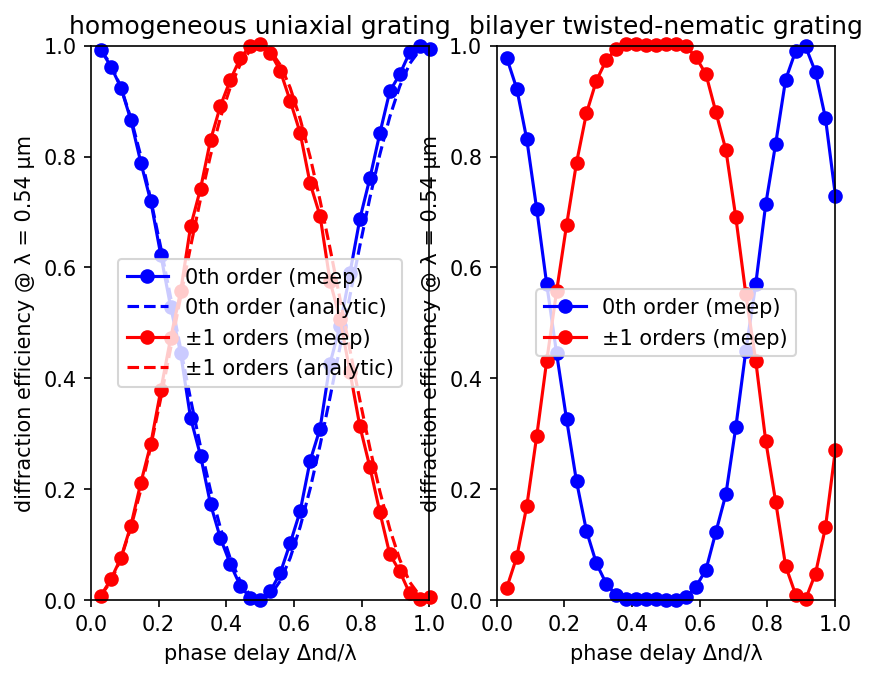

In [4]:
ph_uniaxial = 0  # chiral layer twist angle for uniaxial grating
ph_twisted = 70  # chiral layer twist angle for bilayer grating
gp = 6.5  # grating period
nmode = 5  # number of mode coefficients to compute
dd = np.arange(0.1, 3.5, 0.1)  # chiral layer thickness

m0_uniaxial = np.zeros(dd.size)
m1_uniaxial = np.zeros(dd.size)
ang_uniaxial = np.zeros(dd.size)

m0_twisted = np.zeros(dd.size)
m1_twisted = np.zeros(dd.size)
ang_twisted = np.zeros(dd.size)

for k in range(len(dd)):
    input_flux, angles, coeffs1, coeffs2 = pol_grating(
        0.5 * dd[k], math.radians(ph_uniaxial), gp, nmode
    )
    tran = (abs(coeffs1) ** 2 + abs(coeffs2) ** 2) / input_flux
    for m in range(nmode):
        print(f"tran (uniaxial):, {m}, {angles[m]:.2f}, {tran[m]:.5f}")
    m0_uniaxial[k] = tran[0]
    m1_uniaxial[k] = tran[1]
    ang_uniaxial[k] = angles[1]

    input_flux, angles, coeffs1, coeffs2 = pol_grating(
        dd[k], math.radians(ph_twisted), gp, nmode
    )
    tran = (abs(coeffs1) ** 2 + abs(coeffs2) ** 2) / input_flux
    for m in range(nmode):
        print(f"tran (twisted):, {m}, {angles[m]:.2f}, {tran[m]:.5f}")
    m0_twisted[k] = tran[0]
    m1_twisted[k] = tran[1]
    ang_twisted[k] = angles[1]


cos_angles = [math.cos(math.radians(t)) for t in ang_uniaxial]
tran = m0_uniaxial + 2 * m1_uniaxial
eff_m0 = m0_uniaxial / tran
eff_m1 = (2 * m1_uniaxial / tran) / cos_angles

phase = delta_n * dd / wvl
eff_m0_analytic = [math.cos(math.pi * p) ** 2 for p in phase]
eff_m1_analytic = [math.sin(math.pi * p) ** 2 for p in phase]

plt.figure(dpi=150)
plt.subplot(1, 2, 1)
plt.plot(phase, eff_m0, "bo-", clip_on=False, label="0th order (meep)")
plt.plot(phase, eff_m0_analytic, "b--", clip_on=False, label="0th order (analytic)")
plt.plot(phase, eff_m1, "ro-", clip_on=False, label="±1 orders (meep)")
plt.plot(phase, eff_m1_analytic, "r--", clip_on=False, label="±1 orders (analytic)")
plt.axis([0, 1.0, 0, 1])
plt.xticks(list(np.arange(0, 1.2, 0.2)))
plt.xlabel("phase delay Δnd/λ")
plt.ylabel("diffraction efficiency @ λ = 0.54 μm")
plt.legend(loc="center")
plt.title("homogeneous uniaxial grating")

cos_angles = [math.cos(math.radians(t)) for t in ang_twisted]
tran = m0_twisted + 2 * m1_twisted
eff_m0 = m0_twisted / tran
eff_m1 = (2 * m1_twisted / tran) / cos_angles

plt.subplot(1, 2, 2)
plt.plot(phase, eff_m0, "bo-", clip_on=False, label="0th order (meep)")
plt.plot(phase, eff_m1, "ro-", clip_on=False, label="±1 orders (meep)")
plt.axis([0, 1.0, 0, 1])
plt.xticks(list(np.arange(0, 1.2, 0.2)))
plt.xlabel("phase delay Δnd/λ")
plt.ylabel("diffraction efficiency @ λ = 0.54 μm")
plt.legend(loc="center")
plt.title("bilayer twisted-nematic grating")

plt.show()

In [5]:
# 시뮬레이션 라이브러리 불러오기
import meep as mp
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa
from autograd import tensor_jacobian_product, grad
import nlopt
from meep_material import lorentzfit
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
import pickle
import math
import os
import sys

In [ ]:
import numpy as np
import meep as mp
import nlopt
from typing import Tuple

# lorentzfit 함수는 이미 정의되어 있어야 함 (여기선 너가 가지고 있다고 가정함)

def fit_material_from_csv(
    csv_path: str,
    wl_range_nm: Tuple[float, float],
    eps_inf: float = 1.1,
    num_lorentzians: int = 2,
    num_repeat: int = 30,
    opt_tol: float = 1e-25,
    maxeval: int = 50000,
) -> mp.Medium:
    # 데이터 불러오기
    mydata = np.genfromtxt(csv_path, delimiter=",")
    wl = mydata[:, 0]  # nm
    n_complex = mydata[:, 1] + 1j * mydata[:, 2]
    eps_data = np.square(n_complex) - eps_inf  # 유전율에서 eps_inf 보정

    # 파장 범위 필터링
    wl_min, wl_max = wl_range_nm
    idx_start = np.where(wl > wl_min)[0][0]
    idx_end = np.where(wl < wl_max)[0][-1] + 1
    wl_reduced = wl[idx_start:idx_end]
    eps_reduced = eps_data[idx_start:idx_end]
    freqs_reduced = 1 / wl_reduced  # nm → 1/μm (Meep 단위)

    # 최적화 반복
    ps = np.zeros((num_repeat, 3 * num_lorentzians))
    mins = np.zeros(num_repeat)

    for m in range(num_repeat):
        p_rand = [10 ** (np.random.random()) for _ in range(3 * num_lorentzians)]
        ps[m, :], mins[m] = lorentzfit(
            p_rand, freqs_reduced, eps_reduced, nlopt.LD_MMA, opt_tol, maxeval
        )
        print(f"[{m:2d}] RMS error: {mins[m]:.6e} — params: {ps[m, :]}")

    # 최적 피팅 결과 선택
    idx_opt = np.argmin(mins)
    popt = ps[idx_opt, :]
    print(f"\n>> Best fit RMS error = {mins[idx_opt]:.6e}")
    print(f">> Optimal parameters = {popt}")

    # mp.Medium 구성
    E_sus = []

    for i in range(num_lorentzians):
        sigma = popt[3 * i + 0]
        freq = popt[3 * i + 1]
        gamma = popt[3 * i + 2]

        if freq == 0:
            # Drude 항
            E_sus.append(mp.DrudeSusceptibility(frequency=1.0, gamma=gamma, sigma=sigma))
        else:
            # Lorentz 항
            sigma_adj = sigma / freq**2
            E_sus.append(mp.LorentzianSusceptibility(frequency=freq, gamma=gamma, sigma=sigma_adj))

    # 유효 주파수 범위 설정
    freq_min = 1 / wl_max
    freq_max = 1 / wl_min
    freq_range = mp.FreqRange(min=freq_min, max=freq_max)

    return eps_inf, E_sus, freq_range

sio2_data_path = "/home/min/EIDL/Tool/Meep/LGD/Meep code/OLED structure/Layer by Layer check/New fitting/New fitting data/SiO2/Material data/sio2_material_data.csv"
al_data_path   = "/home/min/EIDL/Tool/Meep/LGD/Meep code/OLED structure/Layer by Layer check/New fitting/New fitting data/Al/Material data/al_material_data.csv"
andp_data_path = "/home/min/EIDL/Tool/Meep/LGD/Meep code/OLED structure/Layer by Layer check/New fitting/New fitting data/aNDP/Material data/aNDP_material_data.csv"

eps_inf_sio2, suscept_sio2 = Material_fit(Material_data_csv=sio2_data_path)
eps_inf_al, suscept_al = Material_fit(Material_data_csv=al_data_path)
eps_inf_andp, suscept_andp = Material_fit(Material_data_csv=andp_data_path)